# Spectral estimation

Diven a time series 
\begin{equation}
    x(n)
\end{equation}
with fft spectrum
\begin{equation}
    y(m) = \sum_{n=0}^{N-1}x(n) \exp\{-2\pi i\frac{nm}{N}\}
\end{equation}
or
\begin{equation}
    y(m) = FFT(x(n))
\end{equation}


Power spectrum is defined as
\begin{equation}
    P(m) = |y(m)|^2
\end{equation}

Power spectral density (PSD) of a discrete-time noise signal is given by the FFT of its autocorrelation function, R(k)
\begin{equation}
    PSD(m) = FFT(R(k))
\end{equation}
where the autocorrelation function R(k) is defined as
\begin{equation}
    R(k)=\frac{1}{N}\sum_{n=0}^{N-1}x(n)x(n-k)
\end{equation}
that is
\begin{equation}
    PSD(m) = \sum_{k=0}^{N-1}\frac{1}{N}\sum_{n=0}^{N-1}x(n)x(n-k) \exp\{-2\pi i\frac{km}{N}\}
\end{equation}

\begin{equation}
    PSD(m) = \frac{1}{N}\sum_{n=0}^{N-1}x(n)\exp\{-2\pi i\frac{nm}{N} \} \sum_{k=0}^{N-1}x(n-k) \exp\{2\pi i\frac{(n-k)m}{N}\}
\end{equation}

\begin{equation}
    PSD(m) = \frac{1}{N}|FFT(x(n))|^2
\end{equation}

or
\begin{equation}
    PSD(m) = \frac{1}{N} P(m)
\end{equation}

While the PSD is related to the Power Spectrum by dividing by length of FFT (i.e. length of signal window), the proper estimation of the Autocorrelation funtion $R(k)$ requires a signal length that is typically longer than the FFT, which cannot be done for short signals (transients), even if mathematically possible, but estimate is not reliable.

In [89]:
import numpy as np
import matplotlib.pyplot as plt

fs=192
te=100

tt = np.arange(0,te,1/fs)
ndat=len(tt)


## Spectrum help functions

In [90]:
def mSpectrum(xx,win):
    nwin=len(win)
    nfft=nwin
    yy=np.fft.rfft(xx[:nwin]*win,nfft)
    ff=np.fft.rfftfreq(nfft)
    return yy,ff,win

def mWindow(nwin):
    return np.ones((nwin,))
    #return np.hanning(nwin)


## Noise estimates

RMS =  0.09994394056480846


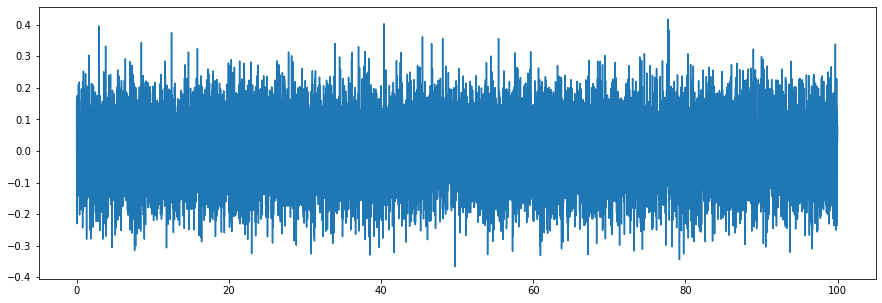

In [91]:

sig=0.1
np.random.seed(1)       # only to ensure same noise signal
xx=np.random.normal(0, sig, ndat)
rms=np.sqrt(np.mean(np.abs(xx)**2))
print("RMS = ",rms)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,xx);

0.09844938830753279 0.09969878122248539 0.09986936714626339


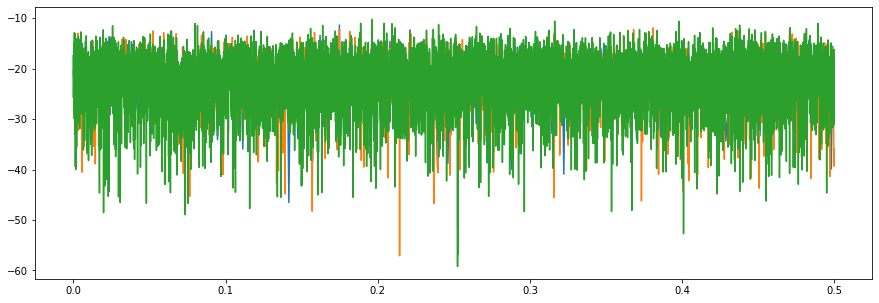

In [92]:
y1,f1,w1 = mSpectrum(xx,mWindow(1024))
y2,f2,w2 = mSpectrum(xx,mWindow(4*1024))
y3,f3,w3 = mSpectrum(xx,mWindow(16*1024))

# RMS scaling
y1 = y1/np.sqrt(sum(w1**2))
y2 = y2/np.sqrt(sum(w2**2))
y3 = y3/np.sqrt(sum(w3**2))

print(np.sqrt(np.mean(np.abs(y1)**2)),np.sqrt(np.mean(np.abs(y2)**2)),np.sqrt(np.mean(np.abs(y3)**2)))

fig = plt.figure("figure.figsize",[15,5])

plt.plot(f1,20*np.log10(np.abs(y1)));
plt.plot(f2,20*np.log10(np.abs(y2)));
plt.plot(f3,20*np.log10(np.abs(y3)));


## Tonal estimates

RMS =  0.7071067811865476
Peak = 1.0


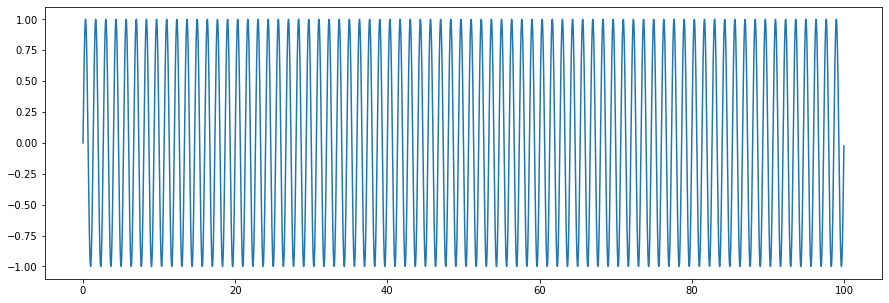

In [93]:
a=1.0
ss=np.sin(2*np.pi*tt*192/256)
rms=a*np.sqrt(np.mean(np.abs(ss)**2))
print("RMS = ",rms)
print("Peak =", np.max(ss))

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,ss);

RMS  = 0.7064172571013567 0.7069342108896063 0.7070636267645375
Peak = 16.0 32.0 64.0


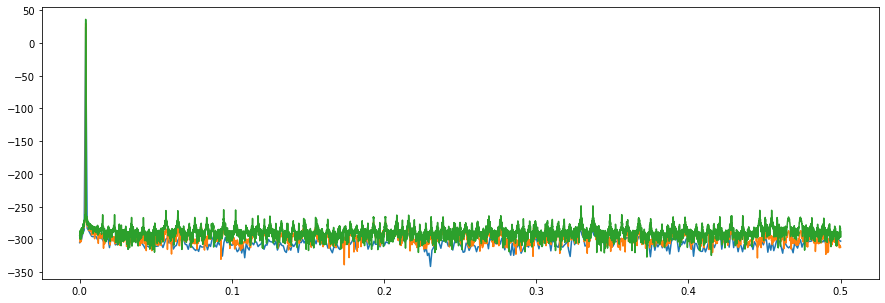

In [94]:
z1,f1,w1 = mSpectrum(ss,mWindow(1024))
z2,f2,w2 = mSpectrum(ss,mWindow(4*1024))
z3,f3,w3 = mSpectrum(ss,mWindow(16*1024))

# RMS scaling
u1 = z1/np.sqrt(np.sum(w1**2))
u2 = z2/np.sqrt(np.sum(w2**2))
u3 = z3/np.sqrt(np.sum(w3**2))


print("RMS  =",np.sqrt(np.mean(np.abs(u1)**2)),np.sqrt(np.mean(np.abs(u2)**2)),np.sqrt(np.mean(np.abs(u3)**2)))
print("Peak =",np.max(np.abs(u1)),np.max(np.abs(u2)),np.max(np.abs(u3)))

fig = plt.figure("figure.figsize",[15,5])

plt.plot(f1,20*np.log10(np.abs(u1)));
plt.plot(f2,20*np.log10(np.abs(u2)));
plt.plot(f3,20*np.log10(np.abs(u3)));


RMS  = 0.044151078568834795 0.022091694090300196 0.011047869168195898
Peak = 1.0 1.0 1.0


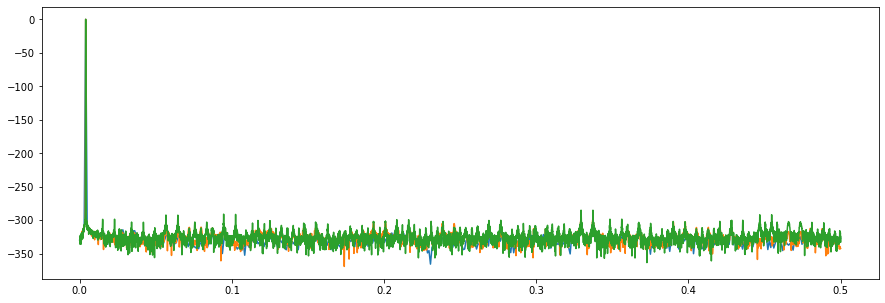

In [95]:
# Peak scaling

u1 = 2*z1/np.sum(w1)
u2 = 2*z2/np.sum(w2)
u3 = 2*z3/np.sum(w3)

print("RMS  =",np.sqrt(np.mean(np.abs(u1)**2)),np.sqrt(np.mean(np.abs(u2)**2)),np.sqrt(np.mean(np.abs(u3)**2)))
print("Peak =",np.max(np.abs(u1)),np.max(np.abs(u2)),np.max(np.abs(u3)))

fig = plt.figure("figure.figsize",[15,5])

plt.plot(f1,20*np.log10(np.abs(u1)));
plt.plot(f2,20*np.log10(np.abs(u2)));
plt.plot(f3,20*np.log10(np.abs(u3)));


## Click estimation

RSS =  7.359497266837217
Peak = 0.7868794322038799


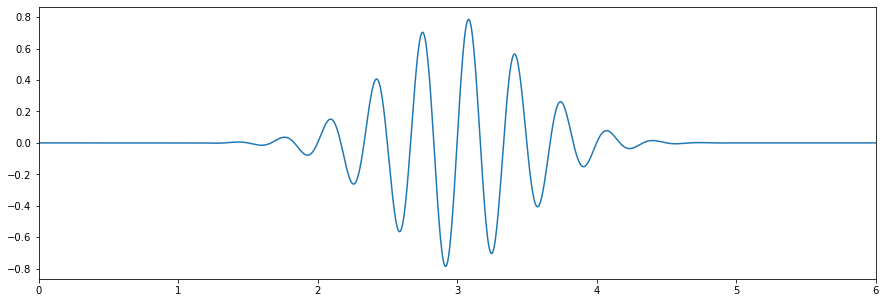

In [96]:
sig=0.5
a=1/(sig*np.sqrt(2*np.pi))*np.exp(-1/2*((tt-3)/sig)**2)
cc=a*np.sin(2*np.pi*tt*192/64)

print("RSS = ",np.sqrt(np.sum(np.abs(cc)**2)))
print("Peak =", np.max(cc))

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,cc);
plt.xlim(0,6);


RMS  = 7.35232076846756 7.3577011722975145 7.359048119891828
Peak = 95.99986188627999 95.99999991429195 95.99999991429195


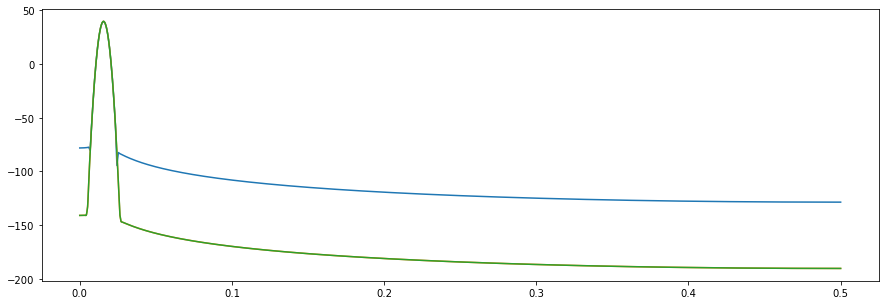

In [97]:

v1,f1,w1 = mSpectrum(cc,np.ones((1024,)))
v2,f2,w2 = mSpectrum(cc,np.ones((4*1024,)))
v3,f3,w3 = mSpectrum(cc,np.ones((16*1024,)))

# RSS scaling (root-sum-squared)
u1 = v1
u2 = v2
u3 = v3

print("RMS  =",np.sqrt(np.mean(np.abs(u1)**2)),np.sqrt(np.mean(np.abs(u2)**2)),np.sqrt(np.mean(np.abs(u3)**2)))
print("Peak =",np.max(np.abs(u1)),np.max(np.abs(u2)),np.max(np.abs(u3)))

fig = plt.figure("figure.figsize",[15,5])

plt.plot(f1,20*np.log10(np.abs(u1)));
plt.plot(f2,20*np.log10(np.abs(u2)));
plt.plot(f3,20*np.log10(np.abs(u3)));


RSS  = 0.06110732534202541 0.061152043479014026 0.061163238361209224
Peak = 0.797883413660844 0.7978845608527171 0.7978845608527171


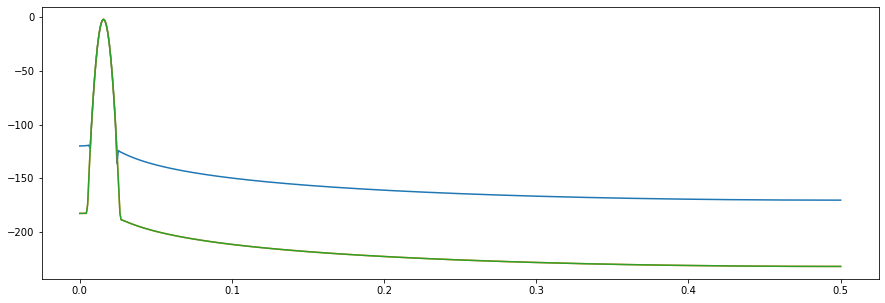

In [98]:
# peak scaling
sc=1/(sig*np.sqrt(2*np.pi)) # using scaling from signal generation

u1 = 2*v1/np.sum(a)*sc
u2 = 2*v2/np.sum(a)*sc
u3 = 2*v3/np.sum(a)*sc

print("RSS  =",np.sqrt(np.mean(np.abs(u1)**2)),np.sqrt(np.mean(np.abs(u2)**2)),np.sqrt(np.mean(np.abs(u3)**2)))
print("Peak =",np.max(np.abs(u1)),np.max(np.abs(u2)),np.max(np.abs(u3)))

fig = plt.figure("figure.figsize",[15,5])

plt.plot(f1,20*np.log10(np.abs(u1)));
plt.plot(f2,20*np.log10(np.abs(u2)));
plt.plot(f3,20*np.log10(np.abs(u3)));
